#  0. 문제정의
*  한국 시총 1위인 삼성전자 주식 선정(개별 종목 중 경제지수와 비슷하게 흘러가고, 찌라시에 덜 영향이 있을거라 생각)
*  삼성전자 종가와 VIX 지수관계 머신러닝으로 확인
*  삼성전자 LSTM으로 딥러닝 

# 1. 데이터 수집

*  삼성전자 2010년 이후 데이터
*  VIX 2010년 이후 데이터


In [1]:
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
!wget $url/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget $url/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
import talib

Selecting previously unselected package libta-lib0.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.6/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 276kB 15.3MB/s 
  Created wheel for ta-lib: filename=TA_Lib-0.4.19-cp36-cp36m-linux_x86_64.whl size=1437799 sha256=047e805fb92c4324e67ceb5b852c39d06c68c5c428f0107c6ac9f35980469c8d
  Stored in directory: /root/.cache/pip/wheels/a3/f6/12/3d1ccd06caadd8fa47e016991dd0d27f1163bb260f1854e2ff
Successfully built ta-lib


In [2]:
from pandas_datareader import data
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn import svm

import seaborn as sns; sns.set()

In [3]:
pip install -U finance-datareader

In [4]:
import FinanceDataReader as fdr

In [43]:
#samsung_st_date = '2010-12-16'
#samsung_enddate = '2020-12-16'
#samsung = data.DataReader('005930.ks', 'yahoo', samsung_st_date, samsung_enddate)
#samsung.head(9)

samsung = fdr.DataReader('005930', '2010') #2010년 이후 삼성 주가 가져옴


In [44]:
samsung

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2010-01-04,16060,16180,16000,16180,239271,0.012516
2010-01-05,16520,16580,16300,16440,559219,0.016069
2010-01-06,16580,16820,16520,16820,459755,0.023114
2010-01-07,16820,16820,16260,16260,443237,-0.033294
2010-01-08,16400,16420,16120,16420,295798,0.009840
...,...,...,...,...,...,...
2020-12-10,72700,73800,72500,72900,39882928,-0.013532
2020-12-11,73500,73800,73100,73400,18486672,0.006859
2020-12-14,73600,74500,73200,73800,21510415,0.005450


In [45]:
samsung.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Change    0
dtype: int64

In [58]:
VIX = fdr.DataReader('VIX', '2010') #2010년 이후 VIX 지수가져옴


## 데이터 시각화

* 삼전종가
* VIX종가
* 삼전 이동평균선
* 삼전과 vix의 관계 그래프 등등

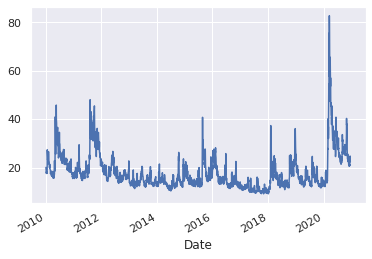

In [59]:
VIX['Close'].plot()


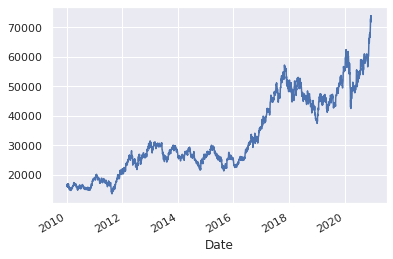

In [60]:
samsung['Close'].plot()

## 수집된 데이터를 기반으로 새로운 데이터 생성
*  

In [61]:
VIX = VIX.drop(['Open','High','Low', 'Volume','Change'], axis=1) 
# 필요없는거 버리고 close만 쓸거임

In [62]:
VIX.columns = ['VIX_Close']
VIX

,VIX_Close
Date,
2010-01-04,20.04
2010-01-05,19.35
2010-01-06,19.16
2010-01-07,19.06
2010-01-08,18.13
...,...
2020-12-10,22.52
2020-12-11,23.31
2020-12-14,24.72


In [63]:
VIX.isnull().sum()

VIX_Close    0
dtype: int64

In [64]:
snv = pd.concat([samsung,VIX],axis=1)
snv

,Open,High,Low,Close,Volume,Change,VIX_Close
Date,,,,,,,
2010-01-04,16060.0,16180.0,16000.0,16180.0,239271.0,0.012516,20.04
2010-01-05,16520.0,16580.0,16300.0,16440.0,559219.0,0.016069,19.35
2010-01-06,16580.0,16820.0,16520.0,16820.0,459755.0,0.023114,19.16
2010-01-07,16820.0,16820.0,16260.0,16260.0,443237.0,-0.033294,19.06
2010-01-08,16400.0,16420.0,16120.0,16420.0,295798.0,0.009840,18.13
...,...,...,...,...,...,...,...
2020-12-10,72700.0,73800.0,72500.0,72900.0,39882928.0,-0.013532,22.52
2020-12-11,73500.0,73800.0,73100.0,73400.0,18486672.0,0.006859,23.31
2020-12-14,73600.0,74500.0,73200.0,73800.0,21510415.0,0.005450,24.72


In [65]:
snv.isnull().sum()
# 한국과 미국 영업일이 달라서 합쳤을 때 결측치가 생겨버림..

Open         136
High         136
Low          136
Close        136
Volume       136
Change       136
VIX_Close     79
dtype: int64

In [66]:
snv = snv.dropna()
# 없애버리자

In [67]:
snv.info()
# 건수가 좀 줄었지만 크게 줄지 않았음..

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2626 entries, 2010-01-04 to 2020-12-16
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2626 non-null   float64
 1   High       2626 non-null   float64
 2   Low        2626 non-null   float64
 3   Close      2626 non-null   float64
 4   Volume     2626 non-null   float64
 5   Change     2626 non-null   float64
 6   VIX_Close  2626 non-null   float64
dtypes: float64(7)
memory usage: 164.1 KB


## 머신러닝

In [97]:
#snv['MA5'] = talib.SMA(snv['Close'], timeperiod=5)
#snv['MA10'] = talib.SMA(snv['Close'], timeperiod=10)
#snv['RASD5'] = talib.SMA(talib.STDDEV(snv['Close'], timeperiod=5, nbdev=1),timeperiod=5)
#snv['RASD10'] = talib.SMA(talib.STDDEV(snv['Close'], timeperiod=5, nbdev=1),timeperiod=10)

In [68]:
def moving_average(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    df = df.join(MA)
    return df

In [69]:
snv = moving_average(snv, 10) #10일평균이동선

In [70]:
snv.isnull().sum()

Open         0
High         0
Low          0
Close        0
Volume       0
Change       0
VIX_Close    0
MA_10        9
dtype: int64

In [71]:
snv = snv.dropna()
# 맨앞 9개 날림

In [72]:
len(snv)

2617

In [73]:
snv['target'] = snv['Close'].pct_change()

In [74]:
snv = snv.dropna()

In [75]:
snv['target'].describe()

count    2616.000000
mean        0.000721
std         0.017683
min        -0.080357
25%        -0.009926
50%         0.000409
75%         0.010436
max         0.104706
Name: target, dtype: float64

In [76]:
snv

,Open,High,Low,Close,Volume,Change,VIX_Close,MA_10,target
Date,,,,,,,,,
2010-01-19,17000.0,17000.0,16440.0,16460.0,241308.0,-0.023725,17.58,16384.0,-0.022565
2010-01-20,16460.0,16740.0,16460.0,16680.0,384306.0,0.013366,18.68,16408.0,0.013366
2010-01-21,16400.0,17000.0,16400.0,17000.0,340148.0,0.019185,22.27,16426.0,0.019185
2010-01-22,16800.0,16900.0,16360.0,16500.0,470536.0,-0.029412,27.31,16450.0,-0.029412
2010-01-25,16320.0,16960.0,16300.0,16840.0,412797.0,0.020606,25.41,16492.0,0.020606
...,...,...,...,...,...,...,...,...,...
2020-12-10,72700.0,73800.0,72500.0,72900.0,39882928.0,-0.013532,22.52,70480.0,-0.013532
2020-12-11,73500.0,73800.0,73100.0,73400.0,18486672.0,0.006859,23.31,71000.0,0.006859
2020-12-14,73600.0,74500.0,73200.0,73800.0,21510415.0,0.005450,24.72,71710.0,0.005450


In [77]:
snv['target'] = np.where(snv['target'] >= 0 , 1, -1) # 0보다 높거나 같으면 1, 아니면 -1
snv['target'].value_counts()

 1    1407
-1    1209
Name: target, dtype: int64

In [78]:
snv

,Open,High,Low,Close,Volume,Change,VIX_Close,MA_10,target
Date,,,,,,,,,
2010-01-19,17000.0,17000.0,16440.0,16460.0,241308.0,-0.023725,17.58,16384.0,-1
2010-01-20,16460.0,16740.0,16460.0,16680.0,384306.0,0.013366,18.68,16408.0,1
2010-01-21,16400.0,17000.0,16400.0,17000.0,340148.0,0.019185,22.27,16426.0,1
2010-01-22,16800.0,16900.0,16360.0,16500.0,470536.0,-0.029412,27.31,16450.0,-1
2010-01-25,16320.0,16960.0,16300.0,16840.0,412797.0,0.020606,25.41,16492.0,1
...,...,...,...,...,...,...,...,...,...
2020-12-10,72700.0,73800.0,72500.0,72900.0,39882928.0,-0.013532,22.52,70480.0,-1
2020-12-11,73500.0,73800.0,73100.0,73400.0,18486672.0,0.006859,23.31,71000.0,1
2020-12-14,73600.0,74500.0,73200.0,73800.0,21510415.0,0.005450,24.72,71710.0,1


In [79]:
snv['target'] = snv['target'].shift(-1)

In [80]:
snv = snv.dropna()
#samsung['target'] = samsung['target'].astype(np.int64)
y_var = snv['target']
# 예측에 사용하지 않는 변수 삭제
x_var = snv.drop(['target', 'Open','High','Low', 'Close', 'Volume','Change'], axis=1)
# x값에는 10일 평균이동선과, VIX 지수만 넣어보고 관계를 보자
# y값에는 올랐다, 떨어졌다 즉 1또는 -1

In [81]:
x_var

,VIX_Close,MA_10
Date,,
2010-01-19,17.58,16384.0
2010-01-20,18.68,16408.0
2010-01-21,22.27,16426.0
2010-01-22,27.31,16450.0
2010-01-25,25.41,16492.0
...,...,...
2020-12-09,22.27,69990.0
2020-12-10,22.52,70480.0
2020-12-11,23.31,71000.0


## 모델학습

In [82]:
#훈련 세트와 테스트 세트를 나눈다.
#shuffle=False을 설정해 기간이 섞이지 않도록 만든다.
X_train, X_test, y_train, y_test = train_test_split(x_var, 
                                                    y_var, 
                                                    test_size=0.3, 
                                                    shuffle=False, 
                                                    random_state=3)

#훈련 세트와 테스트 세트에 포함된 양성 샘플(up) 비율을 확인한다.
train_count = y_train.count()
test_count = y_test.count()

print('train set label ratio')
print(y_train.value_counts()/train_count)
print('test set label ratio')
print(y_test.value_counts()/test_count)

train set label ratio
 1.0    0.529508
-1.0    0.470492
Name: target, dtype: float64
test set label ratio
 1.0    0.557962
-1.0    0.442038
Name: target, dtype: float64


In [83]:
def get_confusion_matrix(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_score = roc_auc_score(y_test, pred)
    print('confusion matrix')
    print('accuracy:{0:.4f},precision:{1:.4f},recall:{2:.4f},F1:{3:.4f},ROC AUC score:{4:.4f}'.format(accuracy, precision, recall, f1,roc_score))

In [84]:
xgb_dis = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_dis.fit(X_train, y_train)
xgb_pred = xgb_dis.predict(X_test)

In [85]:
xgb_dis

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [86]:
print(xgb_dis.score(X_train, y_train))

0.7918032786885246


In [87]:
get_confusion_matrix(y_test, xgb_pred)

confusion matrix
accuracy:0.4471,precision:0.5167,recall:0.1416,F1:0.2222,ROC AUC score:0.4872


In [96]:
n_estimators = range(10,20,5)

params = {
    'bootstrap': [True],
    'n_estimators':n_estimators,
    'max_depth':[2,3],
    'min_samples_leaf': [2, 3],
    'min_samples_split': [2, 4, 6, 8],
    'max_features':[2]
}

In [97]:
my_cv = TimeSeriesSplit(n_splits=5).split(X_train)

In [98]:
clf = GridSearchCV(RandomForestClassifier(), params, cv=my_cv, n_jobs=-1)
clf.fit(X_train, y_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f904130c620>,
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_w...
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
  

In [99]:
print('best parameter:\n', clf.best_params_)
print('best prediction:{0:.4f}'.format(clf.best_score_))

best parameter:
 {'bootstrap': True, 'max_depth': 3, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 15}
best prediction:0.5134


In [100]:
pred_con = clf.predict(X_test)
accuracy_con = accuracy_score(y_test, pred_con)
print('accuracy:{0:.4f}'.format(accuracy_con))
get_confusion_matrix(y_test, pred_con)

accuracy:0.4815
confusion matrix
accuracy:0.4815,precision:0.5721,recall:0.2808,F1:0.3767,ROC AUC score:0.5078


## 딥러닝 LSTM

In [130]:
samsung_st_date = '2010-12-16'
samsung_enddate = '2020-12-16'
samsung = data.DataReader('005930.ks', 'yahoo', samsung_st_date, samsung_enddate)
samsung.head(9)
#samsung = fdr.DataReader('005930', '2015') #2010년 이후 삼성 주가 가져옴

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-12-16,18380.0,18160.0,18160.0,18220.0,11684200.0,9.610845
2010-12-17,18580.0,18240.0,18280.0,18520.0,17297200.0,9.769093
2010-12-20,18640.0,18280.0,18340.0,18640.0,16911750.0,9.832390
2010-12-21,18800.0,18500.0,18620.0,18720.0,12599300.0,9.874586
2010-12-22,19060.0,18720.0,18780.0,18780.0,16626800.0,9.906237
2010-12-23,18760.0,18500.0,18720.0,18720.0,10985500.0,9.874586
2010-12-24,18780.0,18500.0,18780.0,18500.0,8471650.0,9.758541
2010-12-27,18600.0,18300.0,18500.0,18440.0,10524200.0,9.726891
2010-12-28,19000.0,18520.0,18560.0,18760.0,15650700.0,9.895689


In [131]:
high_prices = samsung['High'].values
low_prices = samsung['Low'].values
mid_prices = (high_prices + low_prices)/2 # 중간가격

In [132]:
samsung

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-12-16,18380.0,18160.0,18160.0,18220.0,11684200.0,9.610845
2010-12-17,18580.0,18240.0,18280.0,18520.0,17297200.0,9.769093
2010-12-20,18640.0,18280.0,18340.0,18640.0,16911750.0,9.832390
2010-12-21,18800.0,18500.0,18620.0,18720.0,12599300.0,9.874586
2010-12-22,19060.0,18720.0,18780.0,18780.0,16626800.0,9.906237
...,...,...,...,...,...,...
2020-12-10,73800.0,72500.0,72700.0,72900.0,39882928.0,72900.000000
2020-12-11,73800.0,73100.0,73500.0,73400.0,18486672.0,73400.000000
2020-12-14,74500.0,73200.0,73600.0,73800.0,21510415.0,73800.000000


In [133]:
seq_len = 100
sequence_length = seq_len + 1 
result = []
for i in range(len(mid_prices) - sequence_length): 
    result.append(mid_prices[i:i+sequence_length]) 

In [134]:
normalized_data = []
for window in result: 
    normalized_window = [((float(p) / float(window[0]))-1)for p in window] 
    normalized_data.append(normalized_window)
    
result = np.array(normalized_data)
result

array([[ 0.        ,  0.00766284,  0.01039956, ..., -0.02353585,
        -0.00711549, -0.00547345],
       [ 0.        ,  0.00271592,  0.01303639, ..., -0.01466594,
        -0.01303639, -0.02933188],
       [ 0.        ,  0.01029252,  0.02329361, ..., -0.01570964,
        -0.031961  , -0.03304442],
       ...,
       [ 0.        ,  0.        ,  0.01286765, ...,  0.34099265,
         0.34466912,  0.35018382],
       [ 0.        ,  0.01286765,  0.01286765, ...,  0.34466912,
         0.35018382,  0.35753676],
       [ 0.        ,  0.        , -0.0154265 , ...,  0.33303085,
         0.34029038,  0.33756806]])

In [135]:
row = int(round(result.shape[0]*0.9)) 
train = result[:row,:]        
np.random.shuffle(train)       

x_train = train[:,:-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
y_train = train[:,-1]

x_test = result[row:,:-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
y_test = result[row:,-1]

x_train.shape, x_test.shape

((2122, 100, 1), (236, 100, 1))

## 딥러닝 모델생성


In [136]:
model = Sequential() 
model.add(LSTM(100, return_sequences=True, input_shape=(100,1))) #100개
model.add(LSTM(64, return_sequences=False))  
model.add(Dense(1, activation='linear')) 
model.compile(loss='mse', optimizer='rmsprop')

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100, 100)          40800     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 83,105
Trainable params: 83,105
Non-trainable params: 0
_________________________________________________________________


In [137]:
model.fit(x_train, y_train,                 
         validation_data=(x_test, y_test),  
         batch_size=10,                     
         epochs=20)

Epoch 1/20
213/213 [==============================] - 3s 12ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 2/20
213/213 [==============================] - 2s 10ms/step - loss: 6.3282e-04 - val_loss: 0.0011
Epoch 3/20
213/213 [==============================] - 2s 10ms/step - loss: 4.1801e-04 - val_loss: 7.3309e-04
Epoch 4/20
213/213 [==============================] - 2s 10ms/step - loss: 3.2682e-04 - val_loss: 0.0019
Epoch 5/20
213/213 [==============================] - 2s 10ms/step - loss: 2.9786e-04 - val_loss: 4.9383e-04
Epoch 6/20
213/213 [==============================] - 2s 10ms/step - loss: 2.9340e-04 - val_loss: 3.5933e-04
Epoch 7/20
213/213 [==============================] - 2s 10ms/step - loss: 2.9070e-04 - val_loss: 4.8102e-04
Epoch 8/20
213/213 [==============================] - 2s 10ms/step - loss: 2.8296e-04 - val_loss: 6.5601e-04
Epoch 9/20
213/213 [==============================] - 2s 10ms/step - loss: 2.7090e-04 - val_loss: 3.8524e-04
Epoch 10/20
213/213 [==============

## 검증
* 예측

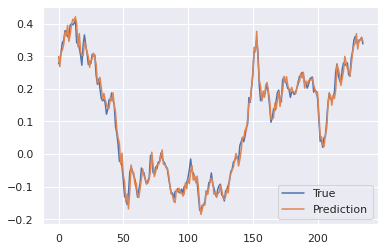

In [138]:
pred = model.predict(x_test) 
fig = plt.figure(facecolor = 'white')
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

In [ ]:
print(pred) 